In [2]:
from configparser import ConfigParser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import kalman

config = ConfigParser()
config.read("config.ini", 'UTF-8')
BTC_PATH = config.get("default", "PATH")

In [7]:
def data_prep():
    df = pd.read_pickle(BTC_PATH)

    # 対数収益率に変換
    df['log_price'] = np.log(df['cl'])

    # 欠損値処理
    df.ffill(inplace=True)
    df.bfill(inplace=True)
    return df

df_all = data_prep()

<Axes: xlabel='timestamp'>

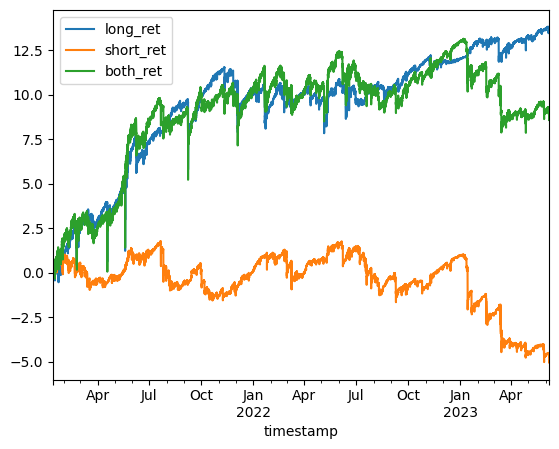

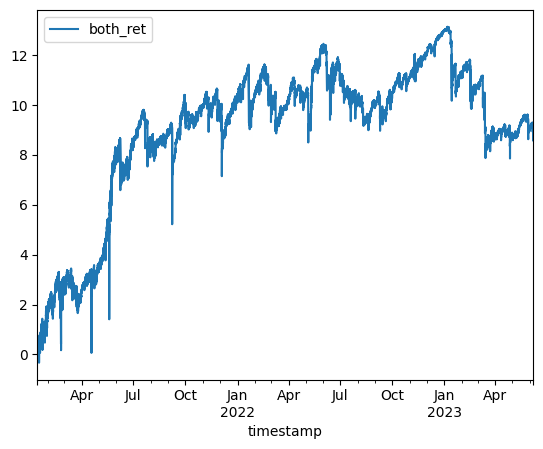

In [8]:
df["cci"] = (df["log_price"] - df["log_price"].rolling(30).mean())/(df["log_price"].rolling(30).std())
df["long_entry"] = (df["cci"] < -2)
df["short_entry"] = (df["cci"] > 2)

df["long_close"] = (df["cci"] > 1)
df["short_close"] = (df["cci"] < -1)

df["long_ret"] = 0.
pos = 0
for i, (idx, entry, close, ret) in enumerate(zip(df.index, df["long_entry"], df["long_close"], df["log_price"].diff().fillna(0))):
    df.loc[idx,"long_ret"] = ret*pos
    if entry:
        pos += 1
    if close:
        pos = 0


df["short_ret"] = 0.
pos = 0
for i, (idx, entry, close, ret) in enumerate(zip(df.index, df["short_entry"], df["short_close"], df["log_price"].diff().fillna(0))):
    df.loc[idx,"short_ret"] = -ret*pos
    if entry:
        pos += 1
    if close:
        pos = 0

df["both_ret"] = df["short_ret"] + df["long_ret"]
# 可視化
df[["long_ret","short_ret", "both_ret"]].iloc[100:].cumsum().plot()
df[["both_ret"]].iloc[100:].cumsum().plot()


In [4]:
su = 0.001
sw = 0.001

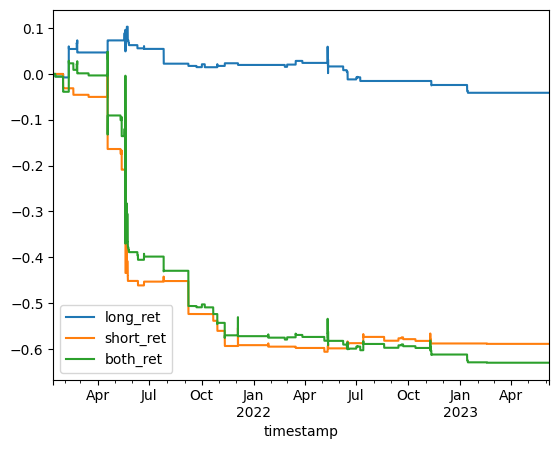

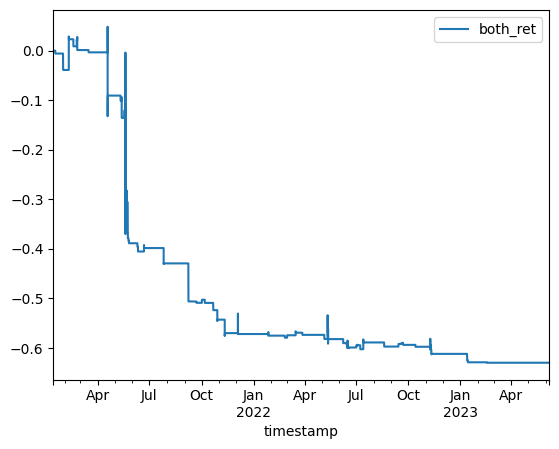

In [6]:
df = df_all.copy()

# 予測
df = kalman.pred_confidence_interval(df, su, sw)

# トレード損益シミュレーション
df = kalman.calc_return(df)

# 可視化
df[["long_ret","short_ret", "both_ret"]].cumsum().plot()
df[["both_ret"]].cumsum().plot()
plt.show()